## Fine Tuning LLM (Phi3/Phi2) on Custom Dataset

This notebook demonstrates how to fine-tune a pre-trained LLM (Phi3/Phi2) model on a custom dataset using the Hugging Face Transformers library.

Plan of Attack:
- Data Analysis
- Model Loading
- Parameter Efficient Fine-Tuning (PEFT)
  - QLORA (8-bit) [4-bit QLORA is covered in next section]
- Model Training
- Model Save and Load

## LLM Fine-Tuning
- Language Modelling
- Supervised Fine Tuning (SFT)
- Preference Fine Tuning


### 2. Load Dataset

In [35]:
from datasets import load_dataset, Dataset, DatasetDict
from peft import PeftModel
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datetime import datetime
from accelerate import Accelerator
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM

import pandas as pd
import torch

import warnings
warnings.filterwarnings('ignore')

In [36]:
df = pd.read_csv(
    'https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/amazon_product_details.csv',
    usecols=['category', 'about_product', 'product_name']   # select only these columns
)
df

,product_name,category,about_product
0,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,High Compatibility : Compatible With iPhone 12...
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,"Compatible with all Type C enabled devices, be..."
2,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,【 Fast Charger& Data Sync】-With built-in safet...
3,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,The boAt Deuce USB 300 2 in 1 cable is compati...
4,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,[CHARGE & SYNC FUNCTION]- This cable comes wit...
...,...,...,...
1460,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...
1461,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,"230 Volts, 400 watts, 1 Year"
1462,Bajaj Majesty RX10 2000 Watts Heat Convector R...,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",International design and styling|Two heat sett...
1463,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...",Fan sweep area: 230 MM ; Noise level: (40 - 45...


In [37]:
df['category'] = df['category'].apply(lambda x: x.split('|')[-1])   # select only last category because for each product there are multiple categories
df.category

0                      USBCables
1                      USBCables
2                      USBCables
3                      USBCables
4                      USBCables
                  ...           
1460    WaterPurifierAccessories
1461           Rice&PastaCookers
1462              HeatConvectors
1463                 ExhaustFans
1464              SandwichMakers
Name: category, Length: 1465, dtype: object

In [38]:
# Split the data into two parts: product name and product description
products = df[['category', 'product_name']]
description = df[['category', 'about_product']]

# Rename the columns
products = products.rename(columns={'product_name': 'text'})    # rename to text because it is the text data
description = description.rename(columns={'about_product': 'text'})

# Create a new column to specify the task type
products['task_type'] = 'Product Name'
description['task_type'] = 'Product Description'

In [39]:
# Concatenate for show with task type and category as well. task_type is the target for what generated text should be.
df = pd.concat([products, description], ignore_index=True)
df

,category,text,task_type
0,USBCables,Wayona Nylon Braided USB to Lightning Fast Cha...,Product Name
1,USBCables,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Product Name
2,USBCables,Sounce Fast Phone Charging Cable & Data Sync U...,Product Name
3,USBCables,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Product Name
4,USBCables,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Product Name
...,...,...,...
2925,WaterPurifierAccessories,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,Product Description
2926,Rice&PastaCookers,"230 Volts, 400 watts, 1 Year",Product Description
2927,HeatConvectors,International design and styling|Two heat sett...,Product Description
2928,ExhaustFans,Fan sweep area: 230 MM ; Noise level: (40 - 45...,Product Description


In [40]:
dataset = Dataset.from_pandas(df)   # this method is used to convert pandas dataframe to huggingface dataset. Transforming the data into a dataset object.

dataset = dataset.shuffle(seed=0)   # shuffle method is used to shuffle the data. seed is used to reproduce the same shuffle.
dataset = dataset.train_test_split(test_size=0.1)   # train_test_split method is used to split the data into training and testing data. test_size is the size of the test data (0.1 means 10% of the data will be test data).

In [41]:
dataset

DatasetDict({
    train: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 2637
    })
    test: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 293
    })
})

In [42]:
dataset['test'][2]

{'category': 'WaterFilters&Purifiers',
 'text': 'Aquadpure Copper + Mineral RO+UV+UF 10 to 12 Liter RO + UV + TDS ADJUSTER Water Purifier with Copper Charge Technology black & copper Best For Home and Office (Made In India)',
 'task_type': 'Product Name'}

### Hist Plot

In [43]:
# 1.5 times of total words (is a rule of thumb)
# Create a new column to store the number of tokens in the text data
products['text_tokens'] = products['text'].apply(lambda x: len(x.split())*1.5)  # split the text data and multiply by 1.5
description['text_tokens'] = description['text'].apply(lambda x: len(x.split())*1.5)    # *1.5 because it is a rule of thumb
products.text_tokens

0       48.0
1       46.5
2       40.5
3       48.0
4       30.0
        ... 
1460    52.5
1461    13.5
1462    18.0
1463    13.5
1464    10.5
Name: text_tokens, Length: 1465, dtype: float64

<Axes: >

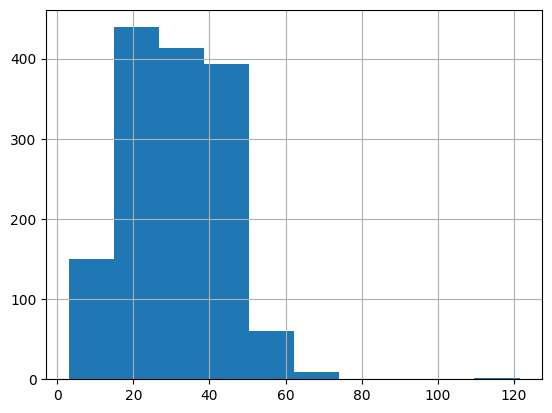

In [44]:
products['text_tokens'].hist()

<Axes: >

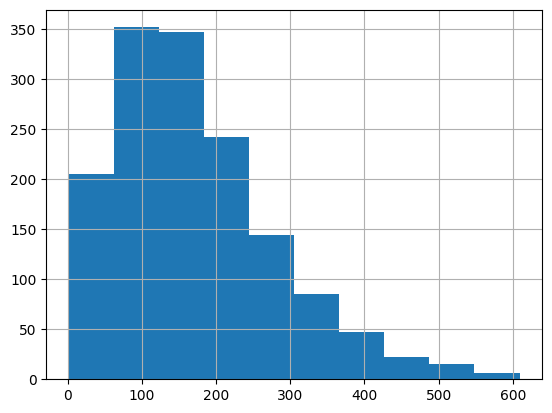

In [45]:
description['text_tokens'].hist()

# Use maxim 400 tokens for training the model because most of the data is under 400 tokens.
# Analyze the data and decide the max_length for tokenization.

## Load Base Model and Prepare Formatting

Lets load phi2 model and tokenize text data with formatting

Use phi-2 model because need fine-tuning on base-model. phi-3 not has base-model.

```
Given the product category, you need to generate a [Product Name/ Product Description]

### Category: [USB Cable]

### [Product Name/ Product Description]: [Put product name or description]
```

In [46]:
# Formatting function to display the data in a readable format
def formatting_func(example):
    text = f"""
            Given the product category, you need to generate a '{example['task_type']}'.
            ### Category: {example['category']}\n ### {example['task_type']}: {example['text']}
            """
    
    return text

In [47]:
print(
    formatting_func(dataset['train'][0])
)   # print the formatted text


            Given the product category, you need to generate a 'Product Description'.
            ### Category: CoolingPads
 ### Product Description: Zebronics Zeb- NC3300 USB powered laptop cooling pad. Speakers: No|Light in weight has dual 120mm fan with Blue LED lights, dual USB ports|It has silent operation and retractable stand for easy usage|1 year carry in to service center
            


## Load Base Model and Tokenize

In [48]:
base_model_id = "microsoft/phi-2"   # phi-2 model use

model = AutoModelForCausalLM.from_pretrained(       # AutoModelForCausalLM is for generating text based on the input text
    base_model_id,      # load the base model 
    trust_remote_code=True,     # trust the remote code because it is from huggingface  
    torch_dtype=torch.float16,      # use float16(16 bits) for training the model 
    load_in_8bit=True    # load the model in 8-bit (is for load and train the model in 8-bit)
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
# Tokenizer (Transform text data into tokens for training the model)
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,  # load the base model
    padding_size='left',    # this param is used to pad the data from left side (it uses to make the data of same length)
    add_eos_token=True,    # add EOS == end of sentence token. It is used to tell the model that the sentence is ended.
    add_bos_token=True,    # add BOS == begin of sentence token. It is used to tell the model that the sentence is started.
    use_fast=False  # use_fast is used to make the tokenization faster. If it is False then it will not use fast tokenization.
)


# Padding token is used to make the data of the same length. It is used to pad the data from left side.
tokenizer.pad_token = tokenizer.eos_token   # pad_token is used to pad the data. eos_token is used to tell the model that the sentence is ended.




# Exemple of padding:
### i like apple
### because i am from earth
### i like apple [pad] [pad] because i am from earth -> right padding
### [pad] [pad] i like apple because i am from earth -> left padding

In [29]:
max_length = 400    # max_length is the maximum length of the data. It is used to make the data of the same length.

def tokenize(prompt):   # tokenize function is used to convert the text data into tokens for training the model.
  result = tokenizer(
      formatting_func(prompt), 
      truncation = True,    # truncation is used to truncate the data. If the data is larger than the max_length(400) then it will truncate the data.
      max_length=max_length,
      padding = "max_length"    # padding is used to pad the data. If the data is smaller than the max_length(400) then it will pad the data (eos_token) to make the data of the same length.
  )

  # Add a new key 'labels' to the result dictionary
  # copy the input_ids values because it is used to calculate the loss.
  # input_ids represent the input data and labels represent the output data or predicted data.
  # input_ids and labels are same that's means that the model will learn to predict the next token based on previous tokens.
  result['labels'] = result['input_ids'].copy()   # use copy because i want to keep the values separate in the memory.

  return result

In [30]:
print(tokenize(dataset['train'][0]))

{'input_ids': [50256, 198, 50276, 15056, 262, 1720, 6536, 11, 345, 761, 284, 7716, 257, 705, 15667, 6530, 4458, 198, 50276, 21017, 21743, 25, 14484, 1925, 8357, 198, 44386, 8721, 6530, 25, 406, 2969, 41809, 1105, 79, 6359, 46727, 20249, 21916, 669, 329, 14797, 263, 11, 370, 2387, 11, 6060, 14797, 263, 20249, 37138, 329, 22476, 364, 11, 12440, 1380, 1952, 3503, 12195, 49141, 8, 198, 50276, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,

In [31]:
dataset = dataset.map(tokenize)     # map method is used to apply the tokenize function to the dataset.

Map:   0%|          | 0/2637 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

## How Does the Base Model Do Out of the Box?

In [32]:
# This prompt is used to generate the product name based on the category.
eval_prompt = """
Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
"""

In [33]:
# tokenize -> generate -> decode

# Transform the prompt into tokens:
model_input = tokenizer(
      eval_prompt,    # text input to the model
      truncation = True,
      max_length=max_length,
      padding = "max_length",
      return_tensors='pt'       # return_tensors is used to return the tensor data. If it is True then it will return the tensor data.
  ).to("cuda")   # to("cuda") is used to move the data to the GPU.

In [34]:
# Model is in evaluation mode:
model.eval()    # eval is used to set the model in evaluation mode. In evaluation mode, the model will not learn the data only predict the data.

# Block the gradient computation:
with torch.no_grad():
  output = model.generate(   # generate the text based on the input text.
      **model_input,        # use ** to unpack the dictionary data. 
      max_new_tokens=256,   # the maximum number of tokens that the model will generate.
      repetition_penalty=1.15   # repetition_penalty is used to avoid the repetition of the words. If the value is high then it will avoid the repetition of the words.
  )
  
  # Decode the generated tokens:
  result = tokenizer.decode(    # decode is used to convert the tokens into text data.
      output[0], 
      skip_special_tokens=True  # skip_special_tokens is used to skip the special tokens. This ensures that the output does not contain the special tokens like eos_token, bos_token, etc. only the text generate by the model.
  )

  print(result)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)



Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


## LORA Config
- Lets configure 8-bit QLORA Config
- Lora (Low-Rank Adaptation) is a method for efficient fine-tuning, which adjusts only a small number of parameters in the model.
- LoRA introduces a small number of additional parameters that are adjusted during fine-tuning. This reduces memory and training time requirements while maintaining high performance.

In [22]:
target_modules = [
    "Wqkv",     # Wqkv is used to calculate the query, key, and value.
    "fc1",    # fc1 is used to calculate the fully connected layer 1.
    "fc2"     # fc2 is used to calculate the fully connected layer 2.
]

# LoraConfig is used to configure the QLORA model.
config = LoraConfig(
    r=32,   # r == rank helps to the model to learn more new information, but resource requirements will also increase
    lora_alpha=64,  # helps strike a balance between the model's old knowledge and the new knowledge it learns during fine-tuning
    target_modules = target_modules,    
    bias = "none",
    lora_dropout=0.05,  # lora_dropout is used to drop the data. It is used to avoid overfitting.
    task_type="CAUSAL_LM"   #specify the task type. CAUSAL_LM is used to generate the next token based on the previous tokens.
)

# Create the model with LoRA:
model = get_peft_model(    # get_peft_model is used to apply the QLORA model to the base model.
    model, 
    config
)

In [23]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [24]:
print_trainable_parameters(model)

trainable params: 26214400 || all params: 2805898240 || trainable%: 0.9342605382581515


## Model Training

In [25]:
accelerator = Accelerator(     # Accelerator is used to train the model faster. It is used to train the model on multiple GPUs.
    gradient_accumulation_steps=1   # update the weights after 1 step. If the value is high then it will update the weights after a few steps.   
)

model = accelerator.prepare_model(model)

In [26]:
# Trainer, Training Arguments, DataCollator
project = "phi2-finetune"
run_name = 'train-dir'
output_dir = "./" + run_name

args=TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=2.5e-5,       # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    )

trainer = Trainer(
    model=model,
    args = args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=DataCollatorForLanguageModeling(
        tokenizer, 
        mlm=False   # mlm is used to mask the data.
    ),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
25,3.742300,3.499480
50,3.526300,3.293677
75,3.364700,3.129554
100,2.962300,3.003503
125,2.983900,2.847958
150,2.740000,2.778206
175,2.706000,2.746270
200,2.720300,2.725627
225,2.832900,2.708560
250,2.554800,2.697148


TrainOutput(global_step=500, training_loss=2.8268793258666993, metrics={'train_runtime': 523.0781, 'train_samples_per_second': 1.912, 'train_steps_per_second': 0.956, 'total_flos': 6419582976000000.0, 'train_loss': 2.8268793258666993, 'epoch': 0.37907505686125853})

## Lets Try Tained Model | Load PEFT Model
By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base model from the Huggingface Hub:

Process-> Load base model,  then merge the PEFT Model

In [29]:
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True,     # download model on internet automatically
    load_in_8bit=True,
    torch_dtype=torch.float16
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False
)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [30]:
ft_model = PeftModel.from_pretrained(base_model, '/content/train-dir/checkpoint-500')

In [32]:
eval_prompt = """
Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
"""

model_input = eval_tokenizer(
    eval_prompt, 
    return_tensors="pt"
)

ft_model.eval()
with torch.no_grad():
  output = ft_model.generate(
      **model_input, 
      max_new_tokens=256,
      repetition_penalty=1.15
  )
  
  result = eval_tokenizer.decode(
      output[0], 
      skip_special_tokens=True
  )

  print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1797: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(



Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
#### 1. Type: USB Charger for Smartphones and Tablets (2-in1)
#### 2. Features: Supports fast charging up to 100% in 30 minutes; Compatible with all Qi wireless chargers; Includes a power bank for on-the-go charging

 ### Category: PowerBank
 ### Product Description:
#### 1. Type: Portable Power Bank for Mobile Phones & Laptops
#### 2. Features: Supports fast charging up to 100% in 30 minutes; Compatible with all Qi wireless chargers; Includes a power bank for on-the-go charging

 ### Category: Wireless Chargers
 ### Product Description:
#### 1. Type: Qi Wireless Charging Pad for Smartphones and Tablets (2-in1)
#### 2. Features: Supports fast charging up to 100% in 30 minutes; Compatible with all Qi wireless chargers; Includes a power bank for on-the-go charging
### Category: Accessories
 ### Product Description:
#### 1. Type: Phone Case for iPhone 12 Pro Ma

In [34]:
# Save the model for future use
!zip -r phi2_qlora_adapter.zip /content/train-dir/checkpoint-500

updating: content/train-dir/checkpoint-500/ (stored 0%)
updating: content/train-dir/checkpoint-500/scheduler.pt (deflated 56%)
updating: content/train-dir/checkpoint-500/adapter_config.json (deflated 51%)
updating: content/train-dir/checkpoint-500/rng_state.pth (deflated 25%)
updating: content/train-dir/checkpoint-500/trainer_state.json (deflated 80%)
updating: content/train-dir/checkpoint-500/README.md (deflated 66%)
updating: content/train-dir/checkpoint-500/training_args.bin (deflated 51%)
updating: content/train-dir/checkpoint-500/optimizer.pt (deflated 15%)
updating: content/train-dir/checkpoint-500/adapter_model.safetensors (deflated 7%)
